In [1]:
from deep_learning_models import *
from helper.dataset_reader import read_tsv
from helper.data_transformer import *
from sklearn.model_selection import train_test_split
from helper.utils import *
import pandas as pd

In [2]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.0
GPU detected: []


In [3]:
merged_data = read_tsv('../../dataset/comlid-data-140422-v1.tsv')

train_data = read_tsv('../../dataset/train.tsv')
val_data = read_tsv('../../dataset/val.tsv')
test_data = read_tsv('../../dataset/test.tsv')

In [4]:
X_train, y_train = input_converter(merged_data, train_data)
X_val, y_val = input_converter(merged_data, val_data)
X_test, y_test = input_converter(merged_data, test_data)

In [5]:
df = list_to_dataframe(merged_data)

In [6]:
words = get_unique_words(df)
tags = get_unique_tags(df)

In [7]:
num_words = len(words)
num_tags = len(tags)
max_len = 100
model = blstm_lstm_model(num_words, num_tags, max_len)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 50)           1344500   
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 50)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         58880     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 100, 32)           20608     
                                                                 
 time_distributed (TimeDistr  (None, 100, 7)           231   

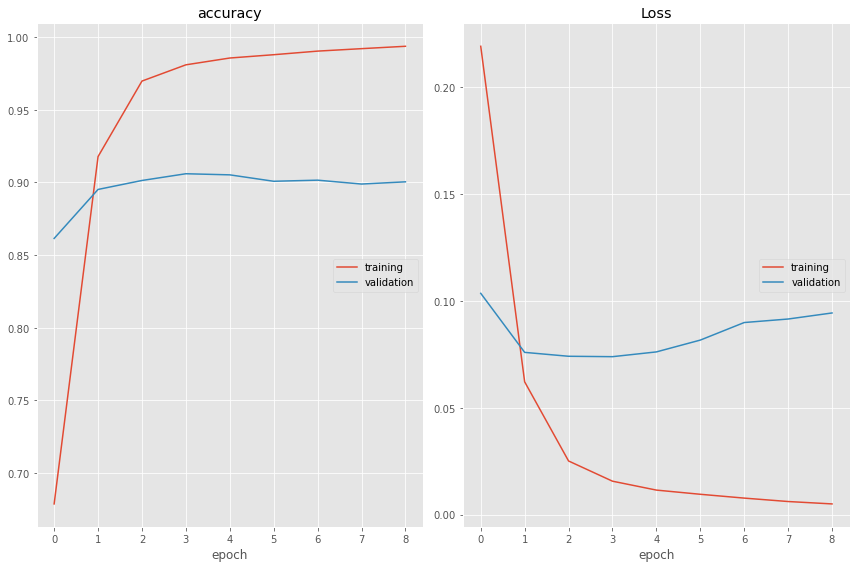

accuracy
	training         	 (min:    0.679, max:    0.994, cur:    0.994)
	validation       	 (min:    0.861, max:    0.906, cur:    0.900)
Loss
	training         	 (min:    0.005, max:    0.219, cur:    0.005)
	validation       	 (min:    0.074, max:    0.104, cur:    0.094)

Epoch 9: val_loss did not improve from 0.07390
56/56 [==============================] - 1s 25ms/step - loss: 0.0908 - accuracy: 0.9000
[0.09083383530378342, 0.8999863266944885]


In [8]:
root_path = 'model/'
model_name = 'blstm_lstm_model.h5'
num_epoch = 50
callbacks = get_callbacks(root_path, model_name)

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=num_epoch,
    callbacks=callbacks,
    verbose=1
)

print(model.evaluate(X_test, y_test))

In [9]:
from keras.models import load_model

mdl = load_model('model/blstm_lstm_model.h5')

In [10]:
all_w_pair = []
all_true_pair = []
all_pred_pair = []

for i in range(len(X_test)):
    p = mdl.predict(np.array([X_test[i]]))
    p = np.argmax(p, axis=-1)
    y_true = y_test[i]
    w_pair = []
    true_pair = []
    pred_pair = []
    for w, true, pred in zip(X_test[i], y_true, p[0]):
        if words[w-1] != "ENDPAD":
            # print("{:30}{:10}\t{}".format(words[w-1], tags[true], tags[pred]))
            w_pair.append(words[w-1])
            true_pair.append(tags[true])
            pred_pair.append(tags[pred])
    all_w_pair.append(w_pair)
    all_true_pair.append(true_pair)
    all_pred_pair.append(pred_pair)

In [11]:
true_flat = [item for sublist in all_true_pair for item in sublist]
pred_flat = [item for sublist in all_pred_pair for item in sublist]

              precision    recall  f1-score   support

          ID     0.9133    0.9520    0.9322     22310
          JV     0.8750    0.8447    0.8596      4913
          EN     0.9112    0.8326    0.8701      5018
   MIX-ID-EN     0.9614    0.8191    0.8846       973
   MIX-ID-JV     0.9914    0.8250    0.9006       280
   MIX-JV-EN     0.9234    0.8267    0.8724       277
           O     0.8890    0.8783    0.8836     10153

    accuracy                         0.9048     43924
   macro avg     0.9235    0.8541    0.8862     43924
weighted avg     0.9048    0.9048    0.9041     43924



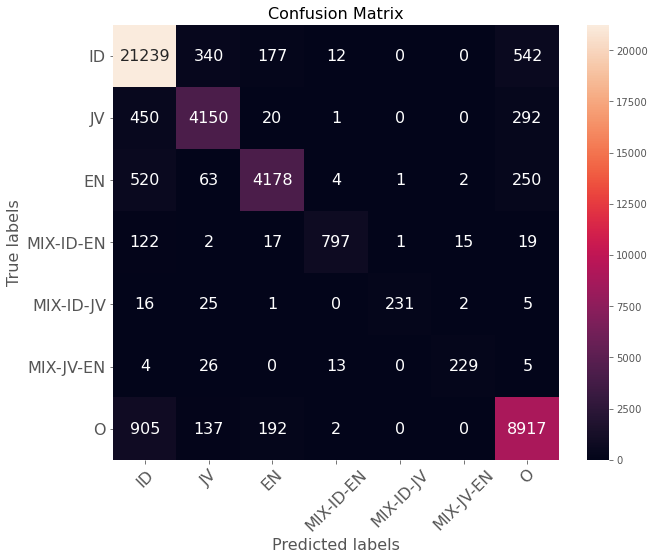

In [12]:
performance_report(true_flat, pred_flat)

In [13]:
i = np.random.randint(0, X_test.shape[0]) #659
p = mdl.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:30}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" *60)

for w, true, pred in zip(X_test[i], y_true, p[0]):
    if words[w-1] != "ENDPAD":
        print("{:30}{:10}\t{}".format(words[w-1], tags[true], tags[pred]))

Word                          True      	 Pred

------------------------------------------------------------
@614chbkist                   O         	O
Aku                           ID        	ID
gabut                         ID        	ID
ini                           ID        	ID
tak                           ID        	ID
carine                        MIX-ID-JV 	MIX-ID-JV
namanya                       ID        	ID
kyungho                       O         	ID
https://t.co/bGvXGkjLyT       O         	O


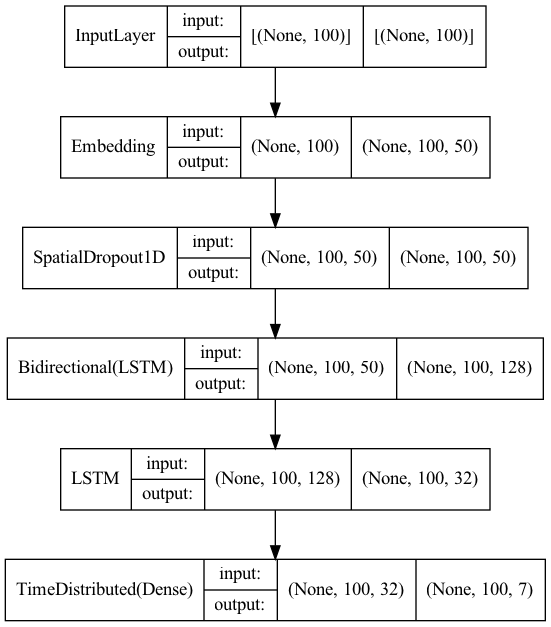

In [14]:
from keras.utils.vis_utils import plot_model
plot_model(mdl, to_file='model_plot/tr_blstm_lstm.png', show_shapes=True, show_layer_names=False)